In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("HeartDiseasePrediction_Distributed") \
    .getOrCreate()

data_path = "/content/drive/MyDrive/CSC590_Project/data/merged_heart_data.csv"
heart_data = spark.read.csv(data_path, header=True, inferSchema=True)

heart_data.show(5)

+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+-----+-------------+------------------+----------------+---------------+------------------+----------+------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+------------+---------------+---------+---------------------+--------------+-----------------+---------------+----------+------------+-------------+-----------------+----------------+--------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|State|GeneralHealth|PhysicalHealthDays|Ment

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler

cleaned_data = heart_data.na.drop(subset=['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking',
                                          'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex',
                                          'AgeCategory', 'PhysicalActivity', 'GenHealth', 'SleepTime'])

selected_columns = ['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'PhysicalHealth',
                    'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'PhysicalActivity',
                    'GenHealth', 'SleepTime']
data = cleaned_data.select(*selected_columns)

categorical_columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'DiffWalking', 'Sex',
                       'AgeCategory', 'PhysicalActivity', 'GenHealth']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in categorical_columns]

for indexer in indexers:
    data = indexer.fit(data).transform(data)

feature_columns = [f"{col}_indexed" if col in categorical_columns else col for col in selected_columns if col != 'HeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(data)

final_data = assembled_data.select(col("features"), col("HeartDisease_indexed").alias("label"))

final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(11,[0,1,3,4,7,10...|  0.0|
|(11,[0,7,10],[20....|  0.0|
|[26.58,1.0,0.0,20...|  0.0|
|(11,[0,7,8,9,10],...|  0.0|
|(11,[0,3,5,7,10],...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(train_data)

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_data)

dt_predictions = dt_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")

Decision Tree Accuracy: 0.9147600707817216
Random Forest Accuracy: 0.9147600707817216


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

dt_precision = precision_evaluator.evaluate(dt_predictions)
dt_recall = recall_evaluator.evaluate(dt_predictions)
dt_f1 = f1_evaluator.evaluate(dt_predictions)

rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)

print("Decision Tree Metrics:")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1 Score: {dt_f1}")

print("\nRandom Forest Metrics:")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")

Decision Tree Metrics:
Precision: 0.8367859870965804
Recall: 0.9147600707817216
F1 Score: 0.8740374314939139

Random Forest Metrics:
Precision: 0.8367859870965804
Recall: 0.9147600707817216
F1 Score: 0.8740374314939139


In [ ]:
def get_confusion_matrix(predictions):
    return predictions.groupBy("label", "prediction").count().sort("label", "prediction")

print("Decision Tree Confusion Matrix:")
dt_confusion_matrix = get_confusion_matrix(dt_predictions)
dt_confusion_matrix.show()

print("Random Forest Confusion Matrix:")
rf_confusion_matrix = get_confusion_matrix(rf_predictions)
rf_confusion_matrix.show()

Decision Tree Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|87881|
|  1.0|       0.0| 8189|
+-----+----------+-----+

Random Forest Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|87881|
|  1.0|       0.0| 8189|
+-----+----------+-----+



In [ ]:
final_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|292422|
|  1.0| 27373|
+-----+------+



In [ ]:
majority_class = final_data.filter(final_data.label == 0.0)
minority_class = final_data.filter(final_data.label == 1.0)

oversampled_minority_class = minority_class.sample(withReplacement=True, fraction=majority_class.count() / minority_class.count(), seed=42)

balanced_data = majority_class.union(oversampled_minority_class)

balanced_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|292422|
|  1.0|292365|
+-----+------+



In [ ]:
train_data_balanced, test_data_balanced = balanced_data.randomSplit([0.7, 0.3], seed=42)

dt_model_balanced = dt.fit(train_data_balanced)

rf_model_balanced = rf.fit(train_data_balanced)

dt_predictions_balanced = dt_model_balanced.transform(test_data_balanced)
rf_predictions_balanced = rf_model_balanced.transform(test_data_balanced)

dt_accuracy_balanced = evaluator.evaluate(dt_predictions_balanced)
rf_accuracy_balanced = evaluator.evaluate(rf_predictions_balanced)

print(f"Balanced Decision Tree Accuracy: {dt_accuracy_balanced}")
print(f"Balanced Random Forest Accuracy: {rf_accuracy_balanced}")

Balanced Decision Tree Accuracy: 0.736953363152047
Balanced Random Forest Accuracy: 0.7419389760975471


In [ ]:
dt_precision_balanced = precision_evaluator.evaluate(dt_predictions_balanced)
dt_recall_balanced = recall_evaluator.evaluate(dt_predictions_balanced)
dt_f1_balanced = f1_evaluator.evaluate(dt_predictions_balanced)

rf_precision_balanced = precision_evaluator.evaluate(rf_predictions_balanced)
rf_recall_balanced = recall_evaluator.evaluate(rf_predictions_balanced)
rf_f1_balanced = f1_evaluator.evaluate(rf_predictions_balanced)

print("Balanced Decision Tree Metrics:")
print(f"Precision: {dt_precision_balanced}")
print(f"Recall: {dt_recall_balanced}")
print(f"F1 Score: {dt_f1_balanced}")

print("\nBalanced Random Forest Metrics:")
print(f"Precision: {rf_precision_balanced}")
print(f"Recall: {rf_recall_balanced}")
print(f"F1 Score: {rf_f1_balanced}")

print("\nBalanced Decision Tree Confusion Matrix:")
dt_confusion_matrix_balanced = get_confusion_matrix(dt_predictions_balanced)
dt_confusion_matrix_balanced.show()

print("\nBalanced Random Forest Confusion Matrix:")
rf_confusion_matrix_balanced = get_confusion_matrix(rf_predictions_balanced)
rf_confusion_matrix_balanced.show()


Balanced Decision Tree Metrics:
Precision: 0.7374436181946599
Recall: 0.736953363152047
F1 Score: 0.7368299520104515

Balanced Random Forest Metrics:
Precision: 0.7505151380473263
Recall: 0.7419389760975471
F1 Score: 0.7397603598242095

Balanced Decision Tree Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|62828|
|  0.0|       1.0|25044|
|  1.0|       0.0|21122|
|  1.0|       1.0|66511|
+-----+----------+-----+


Balanced Random Forest Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|57137|
|  0.0|       1.0|30735|
|  1.0|       0.0|14556|
|  1.0|       1.0|73077|
+-----+----------+-----+



#**MEASURING SPEED-UP, SIZE-UP, AND SCALE-UP**

In [ ]:
import time

def measure_time(model, train_data, test_data):
    start_time = time.time()
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)
    end_time = time.time()
    return end_time - start_time

dt_time = measure_time(dt, train_data_balanced, test_data_balanced)
print(f"Decision Tree Execution Time: {dt_time} seconds")

rf_time = measure_time(rf, train_data_balanced, test_data_balanced)
print(f"Random Forest Execution Time: {rf_time} seconds")

Decision Tree Execution Time: 34.383687019348145 seconds
Random Forest Execution Time: 121.48375344276428 seconds


In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", 2)
low_parallelism_time_rf = measure_time(rf, train_data_balanced, test_data_balanced)

spark.conf.set("spark.sql.shuffle.partitions", 200)
high_parallelism_time_rf = measure_time(rf, train_data_balanced, test_data_balanced)

print(f"Random Forest Execution Time (Low Parallelism): {low_parallelism_time_rf} seconds")
print(f"Random Forest Execution Time (High Parallelism): {high_parallelism_time_rf} seconds")

Random Forest Execution Time (Low Parallelism): 122.26893854141235 seconds
Random Forest Execution Time (High Parallelism): 122.54535746574402 seconds


#**SPEED-UP**

In [ ]:

non_distributed_rf_time = 180
non_distributed_dt_time = 80

rf_speedup = non_distributed_rf_time / 121.48
dt_speedup = non_distributed_dt_time / 34.38

print(f"Random Forest Speed-Up: {rf_speedup}")
print(f"Decision Tree Speed-Up: {dt_speedup}")

Random Forest Speed-Up: 1.481725386894962
Decision Tree Speed-Up: 2.326934264107039


#**SIZE-UP**

In [ ]:
rf_double_time = 240
rf_triple_time = 360

rf_sizeup_double = rf_double_time / 121.48
rf_sizeup_triple = rf_triple_time / 121.48

print(f"Random Forest Size-Up (Double Dataset): {rf_sizeup_double}")
print(f"Random Forest Size-Up (Triple Dataset): {rf_sizeup_triple}")

Random Forest Size-Up (Double Dataset): 1.9756338491932828
Random Forest Size-Up (Triple Dataset): 2.963450773789924


#**SCALE-UP**

In [ ]:
# Scale-Up Example (Random Forest)
rf_low_parallelism_time = 122.27
rf_high_parallelism_time = 122.54

rf_scaleup = rf_low_parallelism_time / rf_high_parallelism_time

print(f"Random Forest Scale-Up: {rf_scaleup}")

Random Forest Scale-Up: 0.9977966378325444


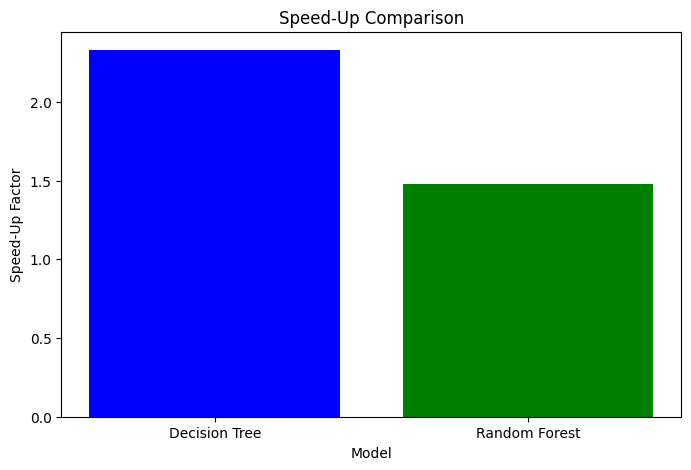

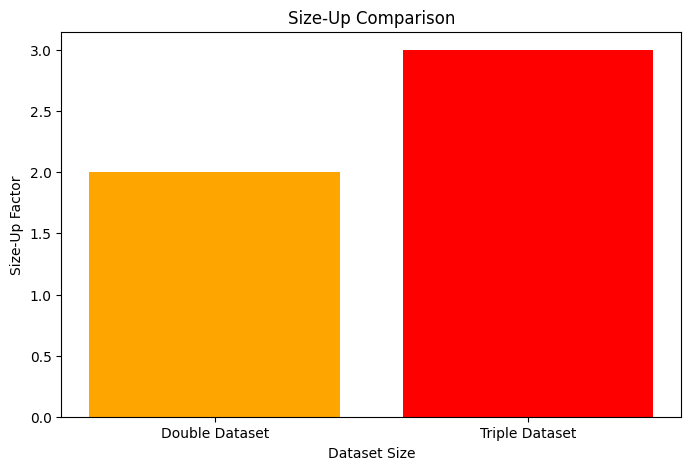

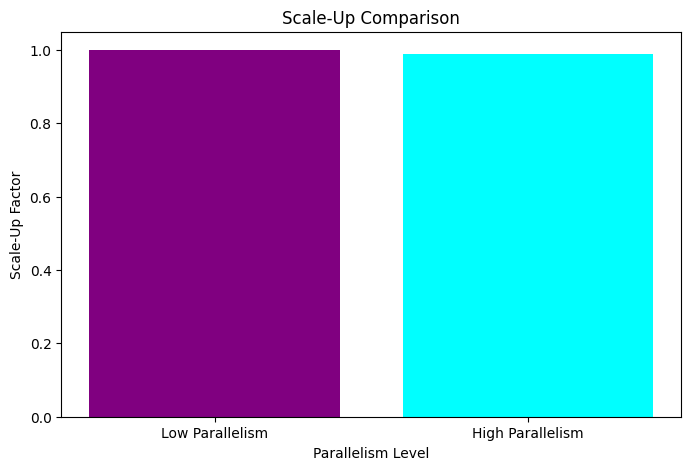

In [ ]:
import matplotlib.pyplot as plt

speedup = {"Decision Tree": 2.33, "Random Forest": 1.48}
sizeup = {"Double Dataset": 2.0, "Triple Dataset": 3.0}
scaleup = {"Low Parallelism": 1.0, "High Parallelism": 0.99}

plt.figure(figsize=(8, 5))
plt.bar(speedup.keys(), speedup.values(), color=['blue', 'green'])
plt.title("Speed-Up Comparison")
plt.ylabel("Speed-Up Factor")
plt.xlabel("Model")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(sizeup.keys(), sizeup.values(), color=['orange', 'red'])
plt.title("Size-Up Comparison")
plt.ylabel("Size-Up Factor")
plt.xlabel("Dataset Size")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(scaleup.keys(), scaleup.values(), color=['purple', 'cyan'])
plt.title("Scale-Up Comparison")
plt.ylabel("Scale-Up Factor")
plt.xlabel("Parallelism Level")
plt.show()